# This is a public notebook example on using the explicit Jacobi iteration and the V_cycle for the 2D electrostatic potential Problem.

## Following Code focuses on Multiprocessing the explicit Jacobi method on CPU using the cython.parallel.prange function

We begin by loading the Cython extension and the appropriate modules. ~ Note> The multiprocessing (mp) module does not work properly in the Jupyter notebook which is why we are using prange.

We define all appropriate functions:

    The 'display' function uses the PIL.Image and takes a 2D array as input to translate into an image. The np.uint8 is the color scheme and bit depth

    The 'jacobi_iteration' performs one full sweep of a given array representation. It has no return so we define it as a void function. It takes as input a 2D array A of 64bit float numbers, and an integer Mask. The Mask serves as a literal Masking method for Dirichlet boundary conditions. Where mask[i,j] = 0 the function will not iterate over. These represent constant values in our Potential A (hence Dirichlet boundary conditions). The Method is being worked on to incorporate Neuman and Mixed B.C. Note!!! => Because this function iterates from 1 => n/m-1 It always represents edges as Dirichlet B.c. This allows us to use them as Ghost Indexes for Neuman B.c where we need to adjust the values to match a derivative of choice. For example A[0] = A[3] means

In this specific function i will use the Boundaries as static Dirichlet conditions with cosinus functions on them.
Yes color scaling in PIL is hell but matplotlib does not support full resolution render and saving with simple syntax.

    The 'Jacobi_fx' uses the 'jacobi_iteration' continiously until a certain number of maximum iterations is reached, or until a convergence criterion is reached. This is represented by the 'error' variable. It is measured by doing the L2 Norm of the array, saving it, then calculating the difference with the L2 norm of the next iteration. Once the L2 norm is small enough (represented by our given error) the iterations stop. The function returns the potential A, the number of iterations and the reached error.

    The 'create_circle' function takes as input an array/Matrix and a Mask matrix along with center coordinates of a circle relative to the index coordinates. It uses the Indexes as the drawing Field along with the mathematical Circle equation x2 + y2 = r**2 to fill the insides of a circle of radius R centered at (x,y). Where x and y are given in index coordinates (i.e they cannot exceed the maximum resolution number -1). The function can be used to fill or hollow out aswell by setting the value to 0 and the mask int to 1 so that is is set as a field coordinate again and not a Dirichlet condition.
    
    The 'create_rectangle' does the same but with a rectangle

The 'Jacobi_fx' has to be defined a cPython function because it will ideally be called in another script if you are working with .pyx files or in other Cells if you are using Jupyter. Same argument for the 'display' function

Testing is done by creating an array of 4K resolution (2160 x 3840 => 8,294,400 elements) (on my AMD 5950x with all cores at 4.6 Ghz this took around 4 minutes) and a Mask of the appropriate size.

In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
""" Remove the """" and run only if following dependencies are not installed
"""
pip install numpy
pip install Cython
pip install matplotlib"""

In [2]:
%load_ext Cython

In [63]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
cimport cython
from cython.parallel import prange
cimport numpy as np
import operator
from libc.math cimport sqrt




operators = {'>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
             '==': operator.eq}

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void jacobi_iteration(double[:,:] A, double[:,:] mask):
    cdef int i, j, n, m
    cdef double tmp
    n, m = A.shape[0], A.shape[1]
    for i in prange(1, n-1, nogil=True):
        for j in range(1, m-1):
            if not mask[i, j]:
                tmp = 0.25 * (A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1])
                A[i, j] = tmp
      

    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple Jacobi_fx_2(double[:,:] A, double[:,:] mask, int max_iterations, double error):
    cdef int i, n, m, iteration
    cdef double norm, norm_prev, tmp_error
    norm_prev = 0
    norm = 0
    iteration = 0
    n, m = A.shape[0], A.shape[1]
    for i in range(max_iterations):
        norm = np.linalg.norm(A)
        jacobi_iteration_2(A, mask)
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return (A, tmp_error, iteration)
    
    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void jacobi_iteration_2(double[:,:] A, double[:,:] mask):
    cdef int i, j, n, m
    cdef double tmp
    n, m = A.shape[0], A.shape[1]
    for i in prange(1, n-1, nogil=True):
        for j in range(1, m-1):
            if not mask[i, j]:
                tmp = 0.2 * (A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1]) + 0.05 * (A[i+1, j+1] + A[i+1, j-1] + A[i-1, j+1] + A[i-1, j-1])
                A[i, j] = tmp
    
    
    
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple Jacobi_fx(double[:,:] A, double[:,:] mask, int max_iterations, double error):
    cdef int i, n, m, iteration
    cdef double norm, norm_prev, tmp_error
    norm_prev = 0
    norm = 0
    iteration = 0
    n, m = A.shape[0], A.shape[1]
    for i in range(max_iterations):
        norm = np.linalg.norm(A)
        jacobi_iteration(A, mask)
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return (A, tmp_error, iteration)




@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef tuple GS_solver(double[:,:] array, double[:,:] mask, int max_iter, double error_threshold):
    cdef int iteration = 0
    cdef double error, error_prev, convergance
    error = 0
    error_prev = 0
    cdef int n, m, row, col
    n, m = array.shape[0], array.shape[1]
    arrayNEW = array.copy()
    while True:
        error_prev = np.linalg.norm(array)
        for row in range(1, n-1):
            for col in range(1, m-1):
                if not mask[row,col]:
                    arrayNEW[row, col] = 0.25*(array[row+1, col] + arrayNEW[row, col-1] + array[row, col+1] + array[row-1, col])
        error = np.linalg.norm(arrayNEW)
        convergance = abs(error-error_prev)
        if iteration > max_iter:
            break
        elif convergance < error_threshold:
            break
        else:
            convergance = 0.
            array = arrayNEW
        iteration = iteration + 1
    return array, iteration, convergance
        
        


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef double[:, :] coarsen_potential(double[:, :] potential, double index_truncation_factor):
    cdef int rows, cols, i, j, inv
    rows = <int>(potential.shape[0] * index_truncation_factor)
    cols = <int>(potential.shape[1] * index_truncation_factor)
    cdef double[:,:] coarsened_potential = np.zeros((rows, cols), dtype=np.float64)
    inv = <int>(1 / index_truncation_factor)
    for i in range(rows):
        for j in range(cols):
            coarsened_potential[i, j] = np.mean(potential[i * inv:i * inv + inv, j * inv:j * inv + inv])
    return coarsened_potential




@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef double[:, :] interpolate_potential(double[:, :] potential, int target_height, int target_width):

    cdef double[:, :] smoothed_potential
    smoothed_potential = np.zeros((target_height, target_width), dtype=np.float64)

    cdef int i, j, ii, jj
    cdef double height_ratio, width_ratio
    height_ratio = potential.shape[0] / target_height
    width_ratio = potential.shape[1] / target_width

    for i in range(target_height):
        for j in range(target_width):
            ii = <int>(i * height_ratio)
            jj = <int>(j * width_ratio)
            smoothed_potential[i, j] = potential[ii, jj]
    return smoothed_potential


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void create_circle(double[:,:] matrix, double[:,:] mask, double x, double y, double radius, double value, double m_value, str param):
    cdef int i, j
    cdef int rows = matrix.shape[0]
    cdef int cols = matrix.shape[1]
    for i in range(rows):
        for j in range(cols):
            if operators[param](((i-y)*(i-y) + (j-x)*(j-x)), radius*radius):
                matrix[i, j] = value
                mask[i, j] = m_value

                
                
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef void create_rectangle(double[:,:] matrix, double[:,:] mask, double x, double y, double width, double height, double value, double m_value, str param):
    cdef int i, j
    cdef int rows = matrix.shape[0]
    cdef int cols = matrix.shape[1]
    cdef double left = x - width / 2
    cdef double right = x + width / 2
    cdef double top = y - height / 2
    cdef double bottom = y + height / 2
    for i in range(rows):
        for j in range(cols):
            if operators[param](left, j) and operators[param](j, right) and operators[param](top, i) and operators[param](i, bottom):
                matrix[i, j] = value
                mask[i, j] = m_value

             
                
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void set_dirichlet(double[:,:] array, double[:,:] mask):
    cdef int i, j
    cdef int rows = array.shape[0]
    cdef int cols = array.shape[1]
    for i in range(rows):
        for j in range(cols):
            if mask[i, j]:
                array[i, j] = mask[i, j]
                
                

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef list up_cycle(double [:,:] potential, double[:,:] mask, int total_samples, int inner_iterations, double index_truncation_factor):
    

    cdef list sample_masks = []
    cdef list modifiable_potential = []
    cdef int number, inner_it, length, pot_count
    

    modifiable_potential.append(coarsen_potential(potential, index_truncation_factor*(1/total_samples)))
    sample_masks.append(mask)
    

    for number in range(total_samples):
        sample_masks.append(coarsen_potential(mask, index_truncation_factor*(1/(number+1))))
        
    length = len(sample_masks) - 1
    pot_count = 0
    
    while length>=0:
        set_dirichlet(modifiable_potential[pot_count], sample_masks[length])

        for inner_it in range(inner_iterations):
            jacobi_iteration(modifiable_potential[pot_count], sample_masks[length])
        
        if length>0:
            modifiable_potential.append(interpolate_potential(modifiable_potential[pot_count], sample_masks[length-1].shape[0], sample_masks[length-1].shape[1]))
        
        length = length-1
        
        pot_count = pot_count +1
    return modifiable_potential


""" #to be tested
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef up_cycle_fx(double [:,:] matrix, double[:,:] mask, int total_samples, int inner_iterations, double index_truncation_factor, int max_iterations, double conv_criterion):
    iteration = 0
    error = 0
    norm = 0
    norm_prev = 0
    cdef int tmp_error
    for i in range(max_iterations):
        norm = np.linalg.norm(matrix)
        up_cycle(matrix, mask, total_samples, inner_iterations, index_truncation_factor)
        error = abs(norm-norm_prev)
        norm_prev = norm
        iteration = iteration + 1
    return matrix, error, iteration
~~~if you are a user feel free to work on this out of curiosity :)~~~       
"""


### A brief explanation on usage:

Begin with the cell below. Define the resolution tuple "res" by inserting Height and Width (rows, columns). Set them at screen resolution for a nice desktop BG

Initialize the empty potential at this resolution with potential = np.zeros(res) aswell as the mask

The rest of the variables are optional

In [64]:
"""!!!"""
"""!!MANDATORY VARIABLES!!"""
"""!!!"""
res = (2160, 3840)
potential = np.zeros(res, dtype=float) 
mask = np.zeros(res, dtype=float)
"""The names 'potential' and 'mask' are variables that go into the keyword arguments of functions like create_circle or create_rectangle """

"""Optional variables"""
"""!!Check if in usage. Probably so!!"""
center_y, center_x = potential.shape[0]//2, potential.shape[1]//2
radius = 950
hollow_radius = 800
small_radius = 600

## Now we can fill The World with objects.

Use syntax : create_circle(matrix, mask, x, y, radius, value, m_value, param)
to create a circle into the 'matrix' and 'mask' arrays. The center of the circle has (x,y) coordinates, a radius, a value in Volts, and a m_value for the mask
param takes a string input depending on the operator logic. It can be ==, >, <, =<, >=. It will define the Fill logic.
For example 

create_circle(potential, mask, center_x, center_y, 400, -50., -50., '<=')

will create a filled circle of radius 400 Units whose inside is of value -50Volts or -50Units for you theoretical people out there

- Try it out!
  Type in the free Cell below:

  - create_circle(potential, mask, center_x, center_y, 400, -50., -50., '<=')
    
    plt.imshow(potential)

and click the Run

- If we type:  (notice the '>=' instead of '<=')

  - create_circle(potential, mask, center_x, center_y, -50., -50., '>=')
    
    plt.imshow(potential)

This swap of the param string will tell the function to fill everything BUT the circle. So it creates an inverted circle. Try it out in another free Cell
and see the difference


Now let's create an interesting scenario

### The lines below get executed in order

We first create a big circle at 100 Volts 

We hollow it out to make it a ring by setting circle 2 to 0 Volts and Mask = 0

We create the Inner circle at -100 Volts

We hollow out rectangular sections.
Then we create some extra rectanglar electrodes at preferred values

Use plt.imshow(potential) to visualize result.
note: ideally you want value and m_value to be the same unless you understand how the algorithm works ^_^

If the result is unsatiscafctory you can reset it but re-running the Cell with the """!!! Mandatory Variables"""

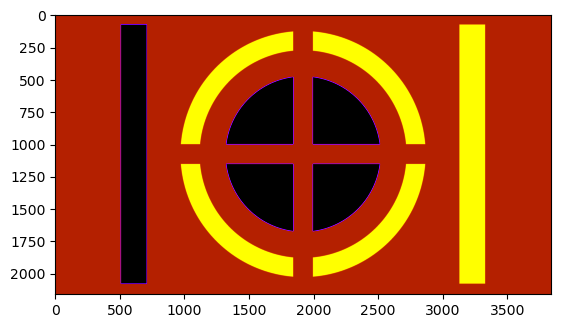

In [65]:
create_circle(potential, mask, center_x, center_y, radius, 100, 100, '<=')
create_circle(potential, mask, center_x, center_y, hollow_radius, 0., 0, '<=')
create_circle(potential, mask, center_x, center_y, small_radius, -100., -100, '<=')
create_rectangle(potential, mask, center_x, center_y, 150, 2000, 0., 0, '<=')
create_rectangle(potential, mask, center_x, center_y, 2000, 150, 0., 0, '<=')
create_rectangle(potential, mask, center_x*0.5-350, center_y, 200, 2000, -100, -100, '<=')
create_rectangle(potential, mask, center_x*1.5+350, center_y, 200, 2000, 100., 100, '<=')
plt.imshow(potential, cmap='gnuplot')

### Now let's call the solver Jacobi_fx to test this.

The function is called as follows.
Jacobi_fx(array, mask, max_iterations, error)

the max_iterations variable specifices what is the max number of iterations the functions is allowed to do before it stops.
The error variable specifies what is the minimum cummulative error that can be reached before the functions stops (convergence is reached)

The function returns a tuple, made out of (result, iterations, error)
Where tuple[0] is the result, tuple[1] is the nr of iterations the program ran and tuple[3] is the error it achieved

Let's run
Jacobi_fx(potential, mask, 10000, 0.09) and equal it to an object

# !Running the line below will Benchmark Your CPU. It might take a while. Open some Telemetry and relax :)

In [66]:
%%time
result2 = Jacobi_fx_2(potential, mask, 15000, 0.7)

Wall time: 7min 46s


### After finishing, a "Wall Time" text appears exectuion time. result[0] holds the actual result. While result[1 and 2] hold the iteration nr and error
### Now let's visualize it in glorious pc master race

In [67]:
result2

(<MemoryView of 'ndarray' at 0x2ad0dbebe00>, 0.7751571990083903, 15000)

# omg that convergance

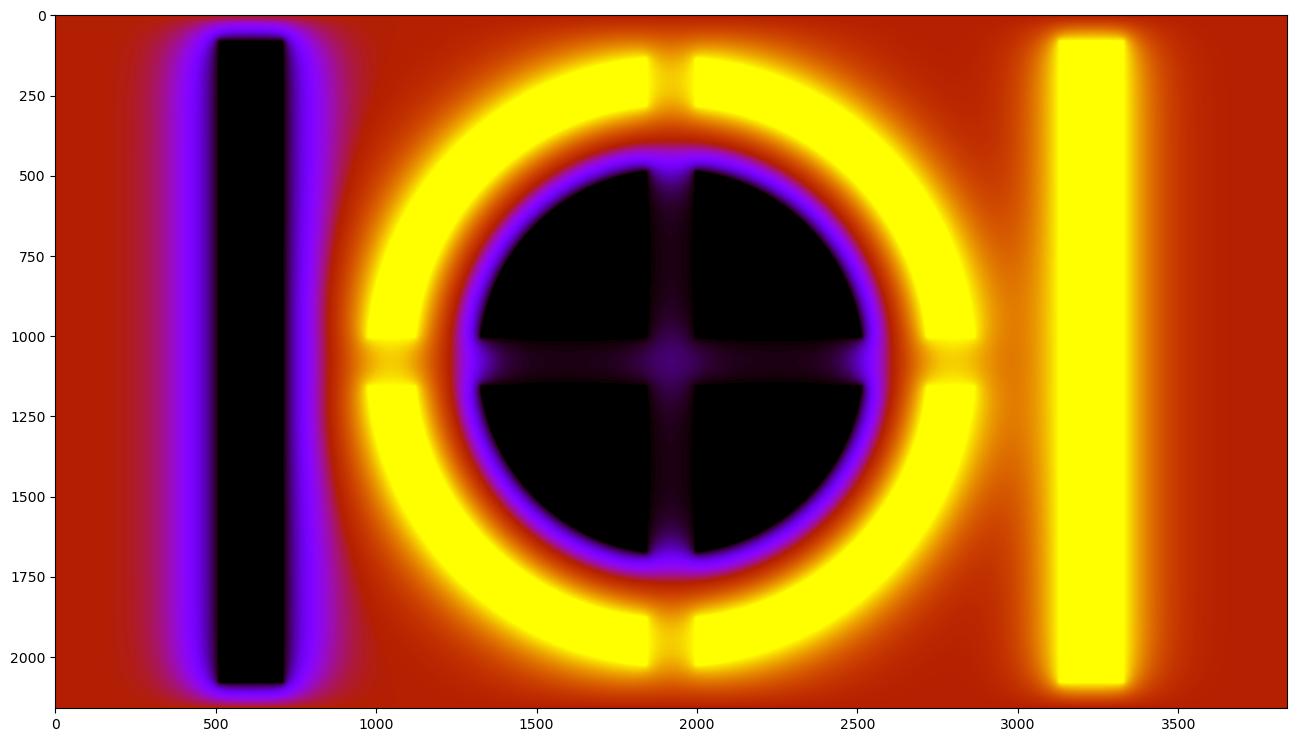

In [68]:
plt.figure(figsize=(16, 9))
plt.imshow(result2[0], cmap='gnuplot')

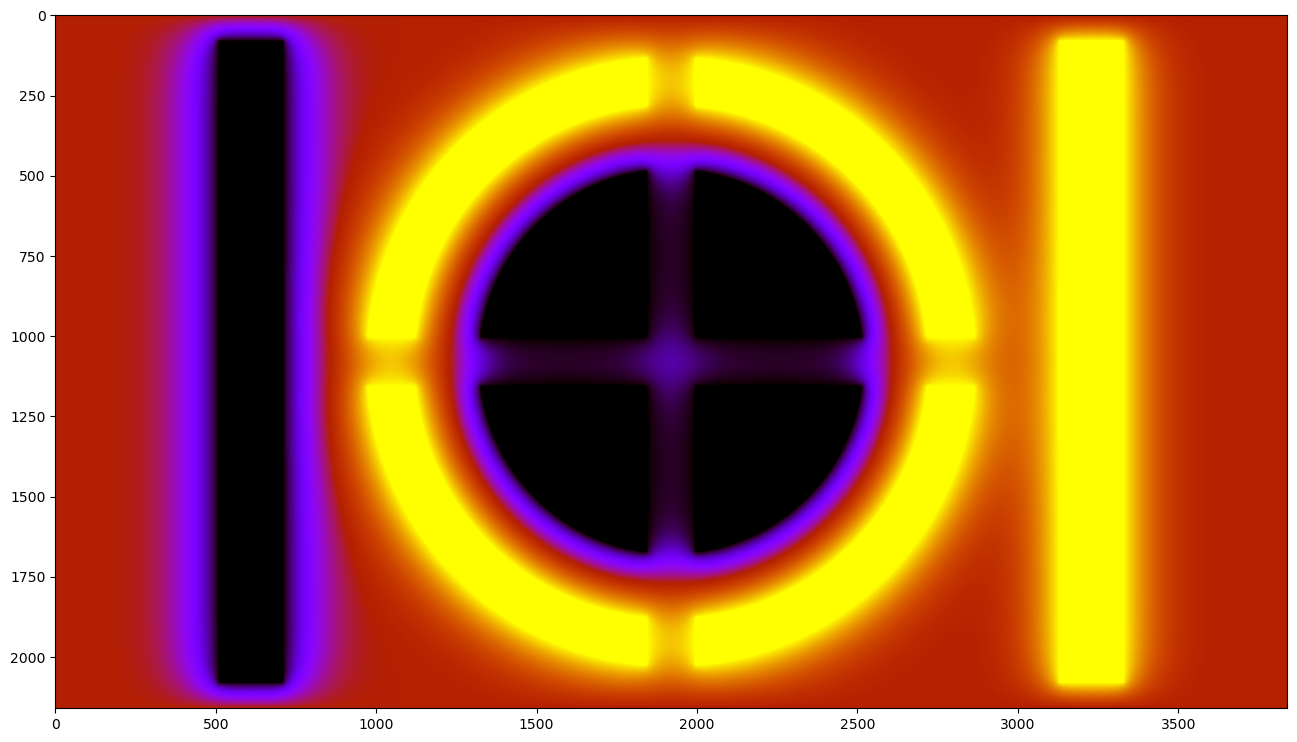

In [69]:
plt.figure(figsize=(16, 9))
plt.imshow(result[0], cmap='gnuplot')

In [27]:
#run to save as desktop bg. 
"""
you can set cmap = '...' for more interesting graphs
'hsv'
'gnuplot'
'gnuplot2'
'viridis'
'plasma'
'inferno'
'spring'
'copper'
'gist_rainbow'
'binary'
"""
plt.imsave('name.png', result[0], cmap='gnuplot', dpi=240)

We also want to know the number of iterations and error so let's call those.
Disapointingly we maxed out the allowed iterations and achieved a pathetic convergance.

In [9]:
result[1], result[2]

(0.7976500313961878, 15000)

Now we want to try the more advanced Up_cycle multigrid method. It will take in a certain nr of allowed downscale samples, a number of iterations and a truncation factor.
For more accurate results until the up_cycle_fx is done, make sure inner_iterations * total_samples is = total_iteration in the jacobi_fx. for ex above is 15000 so if
total_samples= 5 then inner_iterations = 3000

truncation factor is by how much you want to divide the index number every sample, so its the downscaling factor.

In [10]:
total_samples = 5
inner_iterations = 3000
truncation_factor = 0.5

# Before running the cell below make sure you re-run the Cell that defines the geometries
# In[14] and In[15] Cells with all the create_ functions

In [16]:
%%time
cycle_result = up_cycle(potential, mask, total_samples, inner_iterations, truncation_factor)

Wall time: 2min 2s


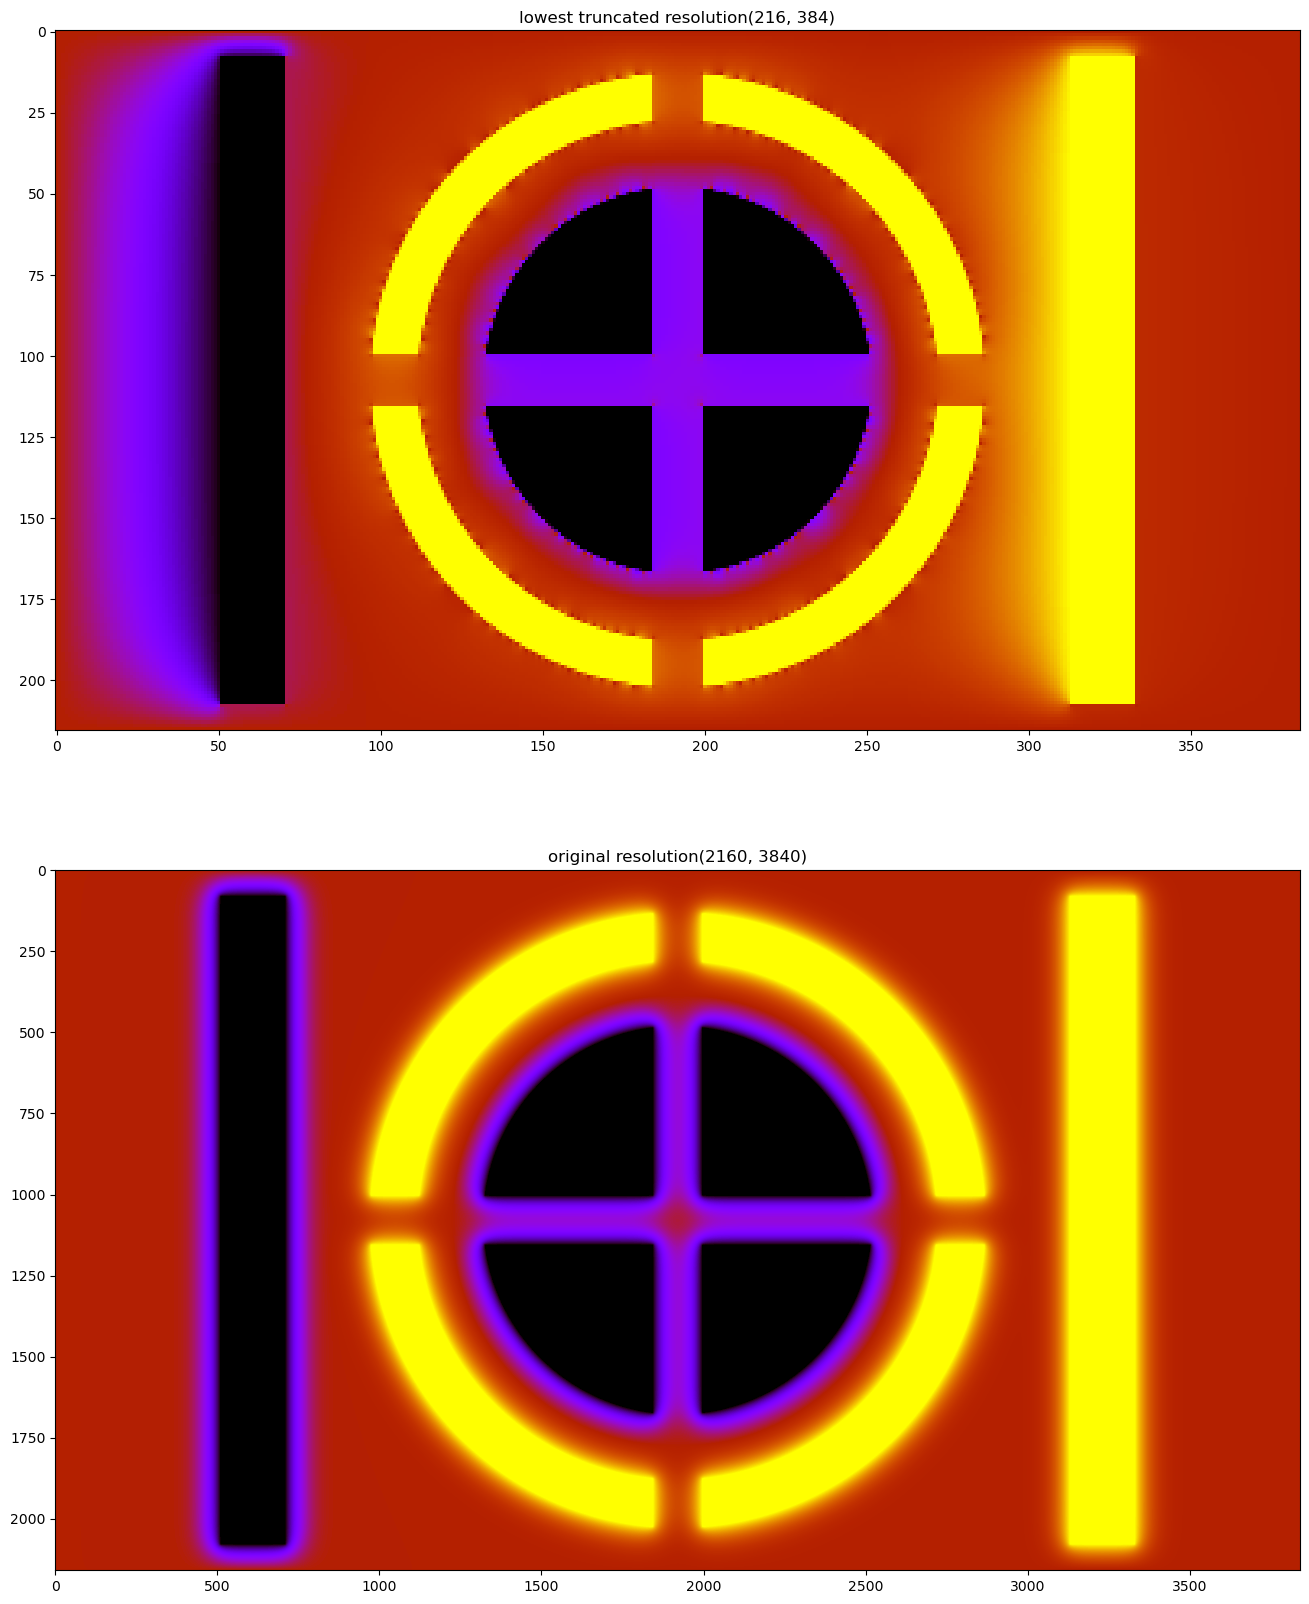

In [17]:
fig = plt.figure(figsize=(35.55, 20))

rows = 2
cols = 1

fig.add_subplot(rows, cols, 1)
plt.imshow(cycle_result[0], cmap='gnuplot')
plt.title("lowest truncated resolution"+str(cycle_result[0].shape))
fig.add_subplot(rows, cols, 2)
plt.imshow(cycle_result[-1], cmap='gnuplot')
plt.title("original resolution"+str(cycle_result[-1].shape))
plt.show()



### Need to look into a convergence algorithm and implement the SOR

In [28]:
"""
more interesting boundaries on the edges ^_^
testside = np.linspace(0.0, 8*np.pi, num=res[0])
testup = np.linspace(0.0, 8*np.pi, num=res[1])

potential[:,0]=35*(np.cos(2*testside))
potential[:,-1]=35*(np.cos(2*testside))
potential[0,:]=35*(np.cos(2*testup))
potential[-1,:]=35*(np.cos(2*testup))


import pygame

# Define the size of the window
WINDOW_SIZE = (1920, 1080)

# Create the Pygame window
pygame.init()
screen = pygame.display.set_mode(WINDOW_SIZE)
pygame.display.set_caption("Potential")

# Define some colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

# Define a color map to improve the color scheme
color_map = [(0, 0, 255 * i // 256) for i in range(256)]

# Start the main loop
running = True
while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Update the potential array
    jacobi_iteration(potential, mask)

    # Create a surface from the potential array
    surface = pygame.surfarray.make_surface(np.rot90(potential, k=1))
    surface.set_palette(color_map)

    # Scale the surface to fit the screen
    surface = pygame.transform.scale(surface, WINDOW_SIZE)

    # Draw the surface on the screen
    screen.blit(surface, (0, 0))

    # Update the screen
    pygame.display.flip()

# Quit Pygame when the main loop exits
pygame.quit()

"""

'\nmore interesting boundaries on the edges ^_^\ntestside = np.linspace(0.0, 8*np.pi, num=res[0])\ntestup = np.linspace(0.0, 8*np.pi, num=res[1])\n\npotential[:,0]=35*(np.cos(2*testside))\npotential[:,-1]=35*(np.cos(2*testside))\npotential[0,:]=35*(np.cos(2*testup))\npotential[-1,:]=35*(np.cos(2*testup))\n\n\nimport pygame\n\n# Define the size of the window\nWINDOW_SIZE = (1920, 1080)\n\n# Create the Pygame window\npygame.init()\nscreen = pygame.display.set_mode(WINDOW_SIZE)\npygame.display.set_caption("Potential")\n\n# Define some colors\nBLACK = (0, 0, 0)\nWHITE = (255, 255, 255)\n\n# Define a color map to improve the color scheme\ncolor_map = [(0, 0, 255 * i // 256) for i in range(256)]\n\n# Start the main loop\nrunning = True\nwhile running:\n    # Handle events\n    for event in pygame.event.get():\n        if event.type == pygame.QUIT:\n            running = False\n\n    # Update the potential array\n    jacobi_iteration(potential, mask)\n\n    # Create a surface from the potenti